En muchas aplicaciones, obtener una representación que sea fácil de entender puede ayudar
a modificar el proceso subyacente que genera los datos o a comprender el procedimiento que
utilizan los expertos humanos para tomar decisiones.

En el ámbito de seguros, los actuarios deciden cuál es el riesgo que corresponde a los diferentes
objetos asegurables analizando datos históricos. Vamos a usar datos de seguros de automóviles del 
repositorio de datos Open ML que se puede obtener usando la función
fetch_openml de scikit-learn usando el nombre autos. El objetivo es la columna symboling
que indica el riesgo de un automóvil dado por los actuarios.

---

In many applications, obtaining a representation that is easy to understand can help modify the underlying process that generates the data or understand the procedure used by human experts to make decisions.

In the insurance industry, actuaries determine the risk associated with different insurable objects by analyzing historical data. We will use automobile insurance data from the OpenML data repository, which can be obtained using the fetch_openml function from scikit-learn using the name "autos". The objective is the column "symboling", which indicates the risk of a given car as determined by actuaries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dtreeviz

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from skopt import BayesSearchCV

In [2]:
# Cargar el conjunto de datos "autos" desde OpenML
autos_data = fetch_openml(name='autos', as_frame=True)
df = autos_data.frame

/Users/alexdominguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/datasets/_openml.py:322: UserWarning: Multiple active versions of the dataset matching the name autos exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=9
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=975



In [3]:
# Transformar el atributo objetivo en dos categorías
df['symboling'] = df['symboling'].astype(int)
print(df['symboling'].value_counts())
df['symboling'] = df['symboling'].apply(lambda x: 0 if x <= 0 else 1)
print(df['symboling'].value_counts())

 0    67
 1    54
 2    32
 3    27
-1    22
-2     3
Name: symboling, dtype: int64
1    113
0     92
Name: symboling, dtype: int64


In [4]:
# Divider en conjutos categoricos y numericos
df_cat = df.select_dtypes(include=['category'])
df_num = df.select_dtypes(exclude=['category'])

imputer = SimpleImputer(strategy='mean')
df_num_imputed = pd.DataFrame(imputer.fit_transform(df_num), columns=df_num.columns)

# Eliminar el atributo objetivo del conjunto de datos numerico
df_num_imputed.drop(columns=['symboling'], inplace=True)
df_y = df['symboling']

print(df_cat.columns)
print(df_num_imputed.columns)
print(df_y.value_counts())

Index(['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style',
       'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders',
       'fuel-system'],
      dtype='object')
Index(['normalized-losses', 'wheel-base', 'length', 'width', 'height',
       'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio',
       'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price'],
      dtype='object')
1    113
0     92
Name: symboling, dtype: int64


In [5]:
# Binarizar las variables categoricas
df_cat_bin = pd.get_dummies(df_cat, drop_first=True)

print(df_cat_bin.columns)

Index(['make_audi', 'make_bmw', 'make_chevrolet', 'make_dodge', 'make_honda',
       'make_isuzu', 'make_jaguar', 'make_mazda', 'make_mercedes-benz',
       'make_mercury', 'make_mitsubishi', 'make_nissan', 'make_peugot',
       'make_plymouth', 'make_porsche', 'make_renault', 'make_saab',
       'make_subaru', 'make_toyota', 'make_volkswagen', 'make_volvo',
       'fuel-type_gas', 'aspiration_turbo', 'num-of-doors_two',
       'body-style_hardtop', 'body-style_hatchback', 'body-style_sedan',
       'body-style_wagon', 'drive-wheels_fwd', 'drive-wheels_rwd',
       'engine-location_rear', 'engine-type_dohcv', 'engine-type_l',
       'engine-type_ohc', 'engine-type_ohcf', 'engine-type_ohcv',
       'engine-type_rotor', 'num-of-cylinders_five', 'num-of-cylinders_four',
       'num-of-cylinders_six', 'num-of-cylinders_three',
       'num-of-cylinders_twelve', 'num-of-cylinders_two', 'fuel-system_2bbl',
       'fuel-system_4bbl', 'fuel-system_idi', 'fuel-system_mfi',
       'fuel-system_mp

In [6]:
# Dividir en conjunto de entrenamiento y prueba (60 %/40 %)
seed = 2024

X_train_cat, X_test_cat, y_train, y_test = train_test_split(df_cat_bin, df_y, test_size=0.4, stratify=df_y, random_state=seed)
X_train_num, X_test_num, y_train, y_test = train_test_split(df_num_imputed, df_y, test_size=0.4, stratify=df_y, random_state=seed)

In [7]:
# Ajustar un árbol de decisión con exploración de hiperparámetros
param = {'criterion':['gini', 'entropy'], 
         'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9],
         'min_samples_leaf':[1,2,3,5,10], 
         'splitter': ['best', 'random'], 
         'max_leaf_nodes':[5, 10, 20, 30]}

dt = DecisionTreeClassifier(random_state=seed)
dt_bs_cat = BayesSearchCV(dt,param,n_jobs=-1, refit=True, random_state=0)
dt_bs_cat.fit(X_train_cat, y_train)

BayesSearchCV(estimator=DecisionTreeClassifier(random_state=2024), n_jobs=-1,
              random_state=0,
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9],
                             'max_leaf_nodes': [5, 10, 20, 30],
                             'min_samples_leaf': [1, 2, 3, 5, 10],
                             'splitter': ['best', 'random']})

In [8]:
cls = [str(v) for v in sorted(df_y.unique())]
print('Class labels:', cls)

Class labels: ['0', '1']


In [9]:
# Evaluar la calidad del modelo en el conjunto de prueba
print(classification_report(y_test, dt_bs_cat.predict(X_test_cat), target_names=cls))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79        37
           1       0.84      0.80      0.82        45

    accuracy                           0.80        82
   macro avg       0.80      0.81      0.80        82
weighted avg       0.81      0.80      0.81        82



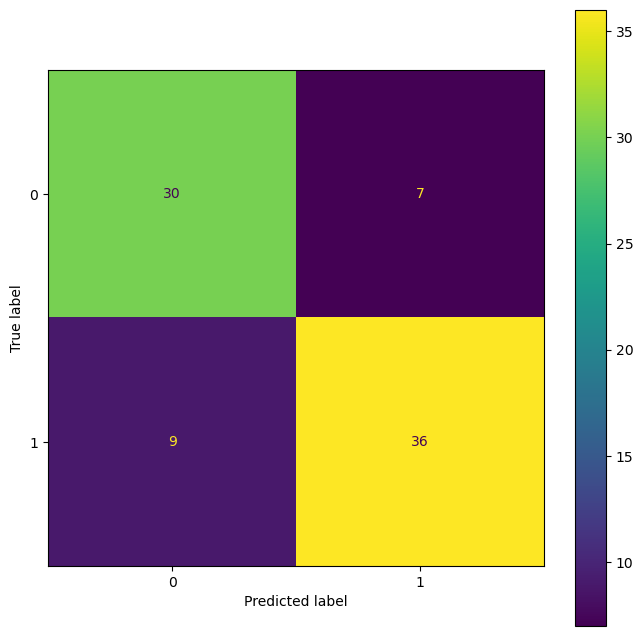

In [10]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(dt_bs_cat, X_test_cat,y_test, display_labels=cls, ax=plt.subplot())

/Users/alexdominguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


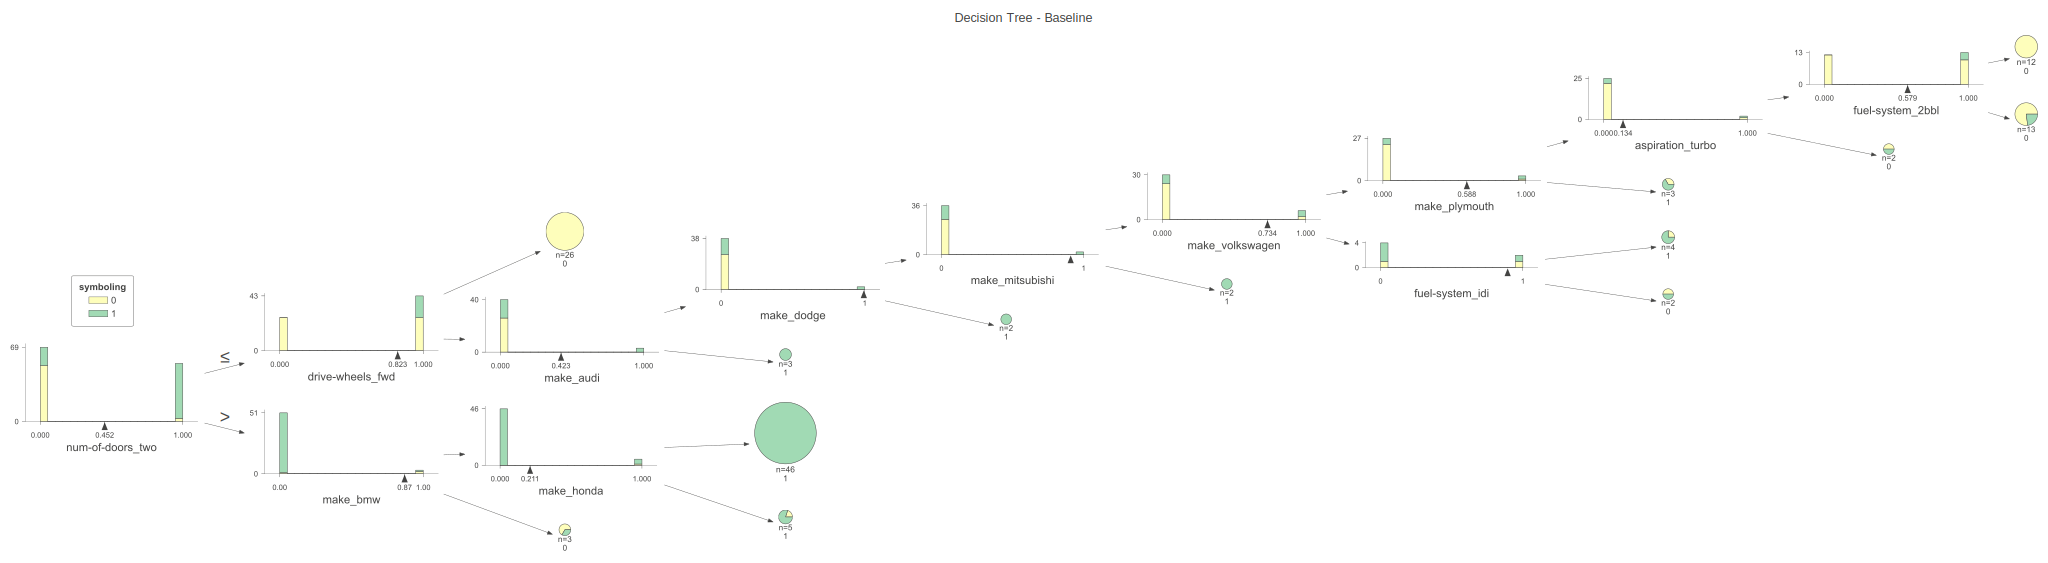

In [11]:
# Visualizar el árbol de decisión con dtreeviz
v_model_cat = dtreeviz.model(dt_bs_cat.best_estimator_, 
               X_train=X_train_cat,
               y_train=y_train,
               target_name='symboling',
               feature_names=X_train_cat.columns,
               class_names=cls
               )
v_model_cat.view(scale=1.5, title="Decision Tree - Baseline",orientation='LR')

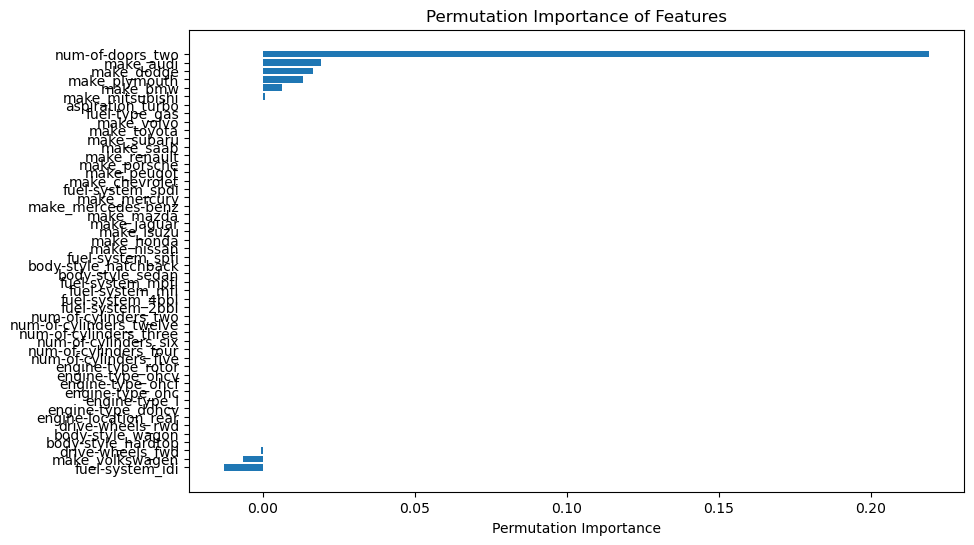

In [12]:
# Calcular la importancia de la permutación con los datos de prueba
perm_importance_cat = permutation_importance(dt_bs_cat, X_test_cat, y_test, n_repeats=30, random_state=seed)
sorted_idx_cat = perm_importance_cat.importances_mean.argsort()

# Visualizar la importancia de los atributos
plt.figure(figsize=(10, 6))
plt.barh(range(X_test_cat.shape[1]), perm_importance_cat.importances_mean[sorted_idx_cat])
plt.yticks(range(X_test_cat.shape[1]), X_test_cat.columns[sorted_idx_cat])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()


In [13]:
# Ajustar un árbol de decisión con datos numéricos
dt_bs_num = BayesSearchCV(dt,param,n_jobs=-1, refit=True, random_state=seed)
dt_bs_num.fit(X_train_num, y_train)

BayesSearchCV(estimator=DecisionTreeClassifier(random_state=2024), n_jobs=-1,
              random_state=2024,
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9],
                             'max_leaf_nodes': [5, 10, 20, 30],
                             'min_samples_leaf': [1, 2, 3, 5, 10],
                             'splitter': ['best', 'random']})

In [14]:
# Evaluar la calidad del modelo en el conjunto de prueba
print(classification_report(y_test, dt_bs_num.predict(X_test_num), target_names=cls))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86        37
           1       0.86      0.93      0.89        45

    accuracy                           0.88        82
   macro avg       0.88      0.87      0.88        82
weighted avg       0.88      0.88      0.88        82



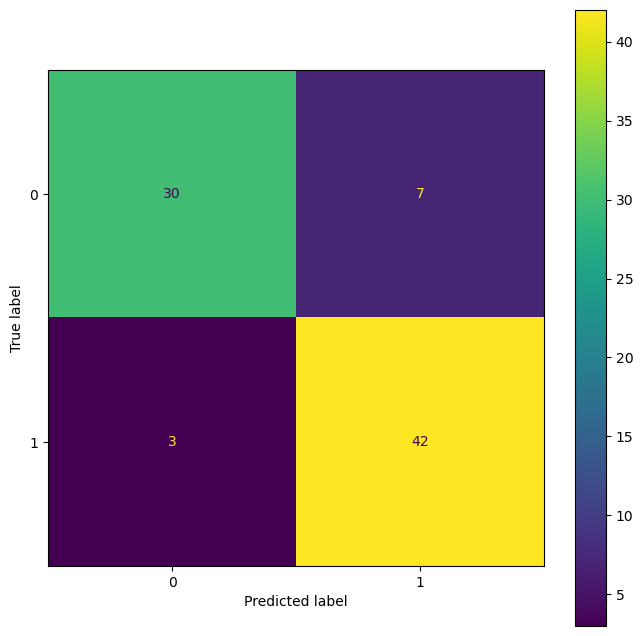

In [15]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(dt_bs_num, X_test_num,y_test, display_labels=cls, ax=plt.subplot())

/Users/alexdominguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


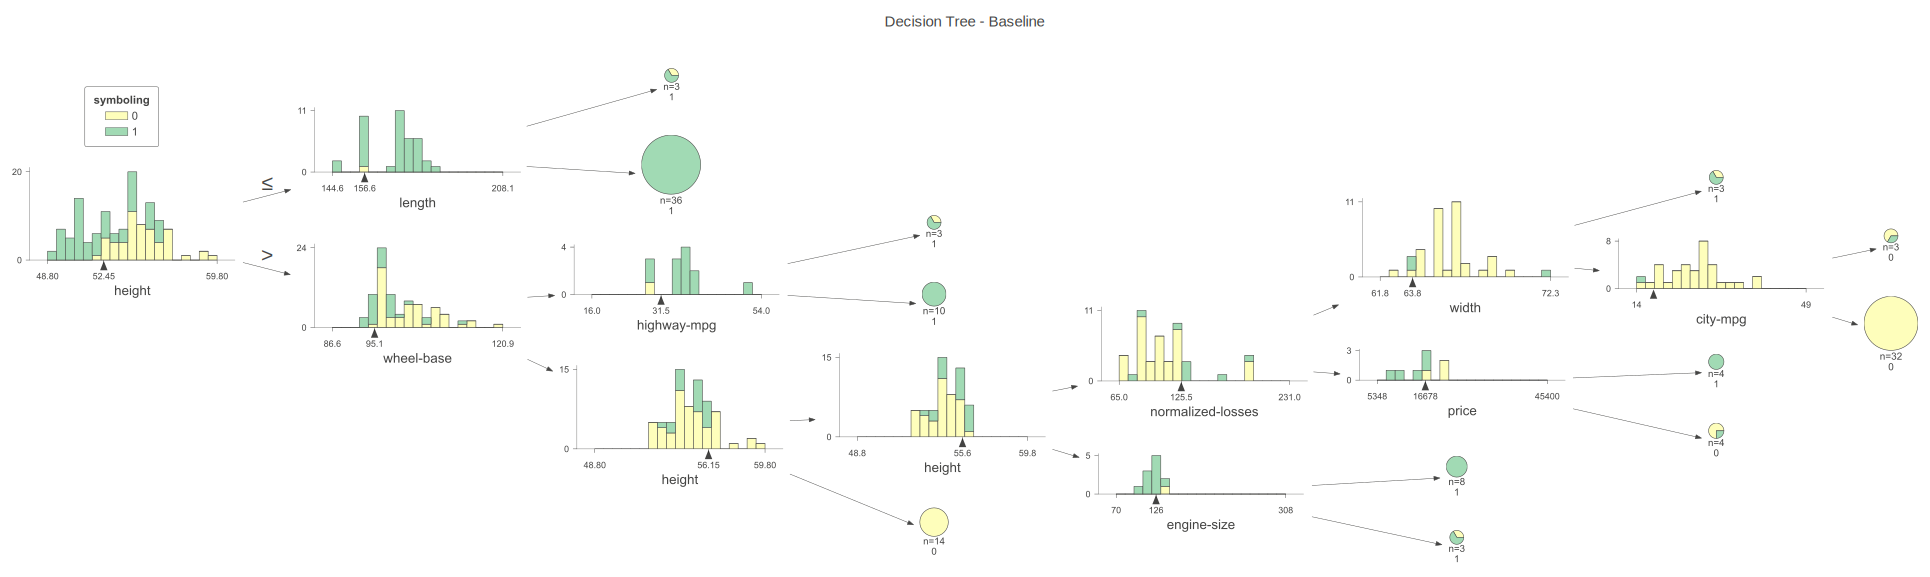

In [16]:
# Visualizar el árbol de decisión con dtreeviz
v_model_num = dtreeviz.model(dt_bs_num.best_estimator_, 
               X_train=X_train_num,
               y_train=y_train,
               target_name='symboling',
               feature_names=X_train_num.columns,
               class_names=cls
               )
v_model_num.view(scale=1.5, title="Decision Tree - Baseline",orientation='LR')

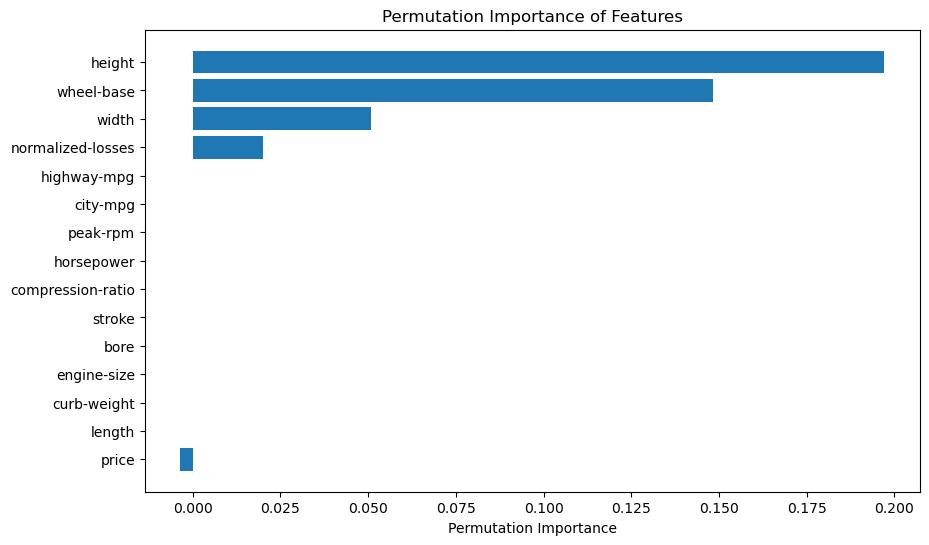

In [17]:
# Calcular la importancia de la permutación con los datos de prueba
perm_importance_num = permutation_importance(dt_bs_num, X_test_num, y_test, n_repeats=30, random_state=seed)
sorted_idx_num = perm_importance_num.importances_mean.argsort()

# Visualizar la importancia de los atributos
plt.figure(figsize=(10, 6))
plt.barh(range(X_test_num.shape[1]), perm_importance_num.importances_mean[sorted_idx_num])
plt.yticks(range(X_test_num.shape[1]), X_test_num.columns[sorted_idx_num])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

Después de ejecutar los dos modelos, vemos que él te ofrece mejores resultados es claramente el que se basa en atributos continuos, es decir numericos.

Por un lado, vemos que en el Classification Report, obtiene mejores valores en todas las métricas que el modelo basado en datos categóricos. También podemos ver, como los dos modelos predicen siete unos como ceros, pero el segundo modelo solo predice tres ceros como unos, mientras el primero predice nueve erroneamente.

Por otro lado, En cuanto a la complejidad del modelo, el primer modelo genera un árbol de decisión de nueve niveles, mientras que el segundo aló genera de siete. De la misma forma, vemos que hay menos atributos involucrados en la decisión del segundo, cinco, que es la del primero, que son nueve. Eso es debido a que el segundo discrimina por altura en varios niveles, mientras el primer modelo no reaprovecha ninguna tributo.

Por tanto, debido a las mejores métricas y a la altura del arbol resultante, nos decantaremos por el modelo obtenido a través de los atributos continuos.

---

After running both models, it is clear that the one based on continuous attributes, i.e., numerical ones, offers better results.

On one hand, in the Classification Report, better values are obtained in all metrics for the model based on categorical data. It is also observed that both models predict seven ones as zeros, but the second model only predicts three zeros as ones, while the first incorrectly predicts nine.

On the other hand, regarding the complexity of the model, the first model generates a decision tree of nine levels, while the second one only generates one of seven. Additionally, it is noted that there are fewer attributes involved in the decision of the second model, five, compared to the first, which are nine. This is because the second model discriminates by height at various levels, while the first one does not reuse any attribute.

Therefore, due to the better metrics and the lower complexity of the resulting tree, we will opt for the model obtained through continuous attributes.

In [18]:
# Unir los conjuntos de datos categoricos y numericos
X_train = pd.concat([X_train_cat, X_train_num], axis=1)
X_test = pd.concat([X_test_cat, X_test_num], axis=1)

# Ajustar un árbol de decisión con datos numéricos y categóricos
dt_bs = BayesSearchCV(dt,param,n_jobs=-1, refit=True, random_state=seed)
dt_bs.fit(X_train, y_train)

BayesSearchCV(estimator=DecisionTreeClassifier(random_state=2024), n_jobs=-1,
              random_state=2024,
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9],
                             'max_leaf_nodes': [5, 10, 20, 30],
                             'min_samples_leaf': [1, 2, 3, 5, 10],
                             'splitter': ['best', 'random']})

In [19]:
# Evaluar la calidad del modelo en el conjunto de prueba
print(classification_report(y_test, dt_bs.predict(X_test), target_names=cls))

              precision    recall  f1-score   support

           0       0.82      0.89      0.86        37
           1       0.90      0.84      0.87        45

    accuracy                           0.87        82
   macro avg       0.86      0.87      0.87        82
weighted avg       0.87      0.87      0.87        82



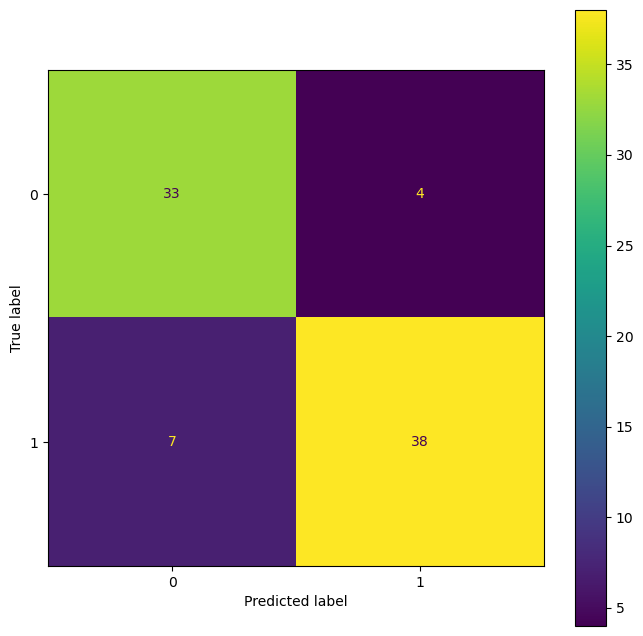

In [20]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(dt_bs, X_test,y_test, display_labels=cls, ax=plt.subplot())

/Users/alexdominguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


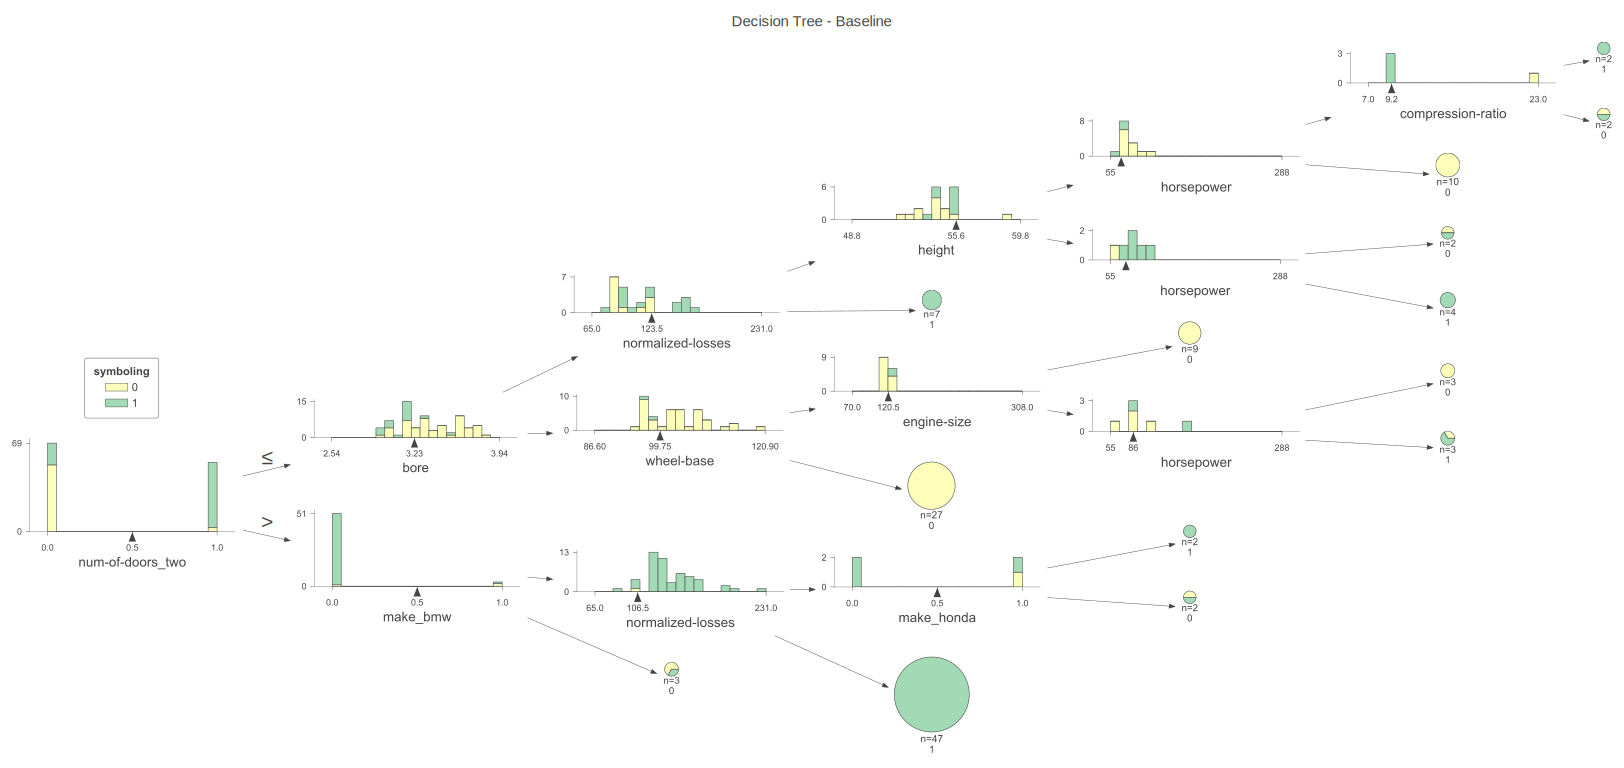

In [21]:
# Visualizar el árbol de decisión con dtreeviz
v_model = dtreeviz.model(dt_bs.best_estimator_, 
               X_train=X_train,
               y_train=y_train,
               target_name='symboling',
               feature_names=X_train.columns,
               class_names=cls
               )
v_model.view(scale=1.5, title="Decision Tree - Baseline",orientation='LR')

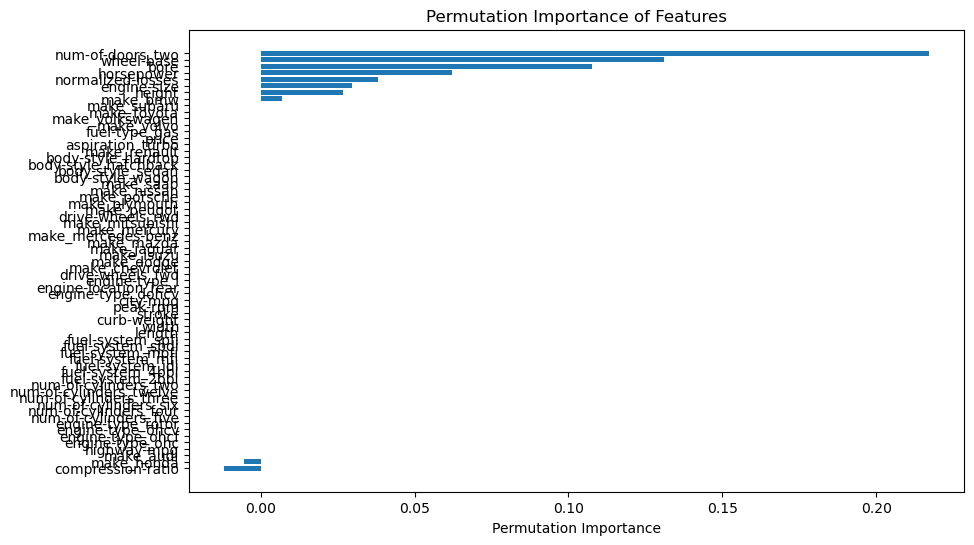

In [22]:
# Calcular la importancia de la permutación con los datos de prueba
perm_importance = permutation_importance(dt_bs, X_test, y_test, n_repeats=30, random_state=seed)
sorted_idx = perm_importance.importances_mean.argsort()

# Visualizar la importancia de los atributos
plt.figure(figsize=(10, 6))
plt.barh(range(X_test.shape[1]), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(X_test.shape[1]), X_test.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()


Después de haber ejecutado el nuevo modelo, no cambiamos nuestra decisión. Nos seguimos quedando con el modelo entrenado partir de los atributos continuos.

Aunque Classification Report, da unos valores parecidos al modelo elegido en el apartado anterior, siguen siendo mejores los obtenidos a través del modelo generado apartir de los atributos continuos, unicamente. En cuanto a la matriz de confusión, es interesante ver que al entrenar el modelo, usando los dos tipos de atributos, obtenemos mejores resultados en la predicción de unos ya que solo se predicen cuatro unos como ceros, mientras que en los otros dos modelos se predecían siete. De todos modos, en cuanto a predecir ceros como unos, el modelo entrenado partir de atributos continúo, sigue siendo mejor.

En cuanto a estructura del árbol, este último modelo es de siete niveles, al igual que el modelo de atributos continuos, pero usa muchos más atributos, diez, por tanto es más complejo.

Como hemos dicho antes, nos quedaremos con el modelo generado a partir de tributos continuos, debido a sus buenos resultados, y a su sencillez.

---

After having executed the new model, we have not changed our decision. We still prefer the model trained using continuous attributes.

Although the Classification Report provides similar values to the model chosen in the previous section, the ones obtained through the model generated from continuous attributes only remain better. Regarding the confusion matrix, it is interesting to note that when training the model using both types of attributes, we obtain better results in predicting ones, as only four ones are predicted as zeros, whereas in the other two models, seven were predicted. However, when it comes to predicting zeros as ones, the model trained using continuous attributes remains better.

Regarding the structure of the tree, this latest model is seven levels deep, just like the model with continuous attributes, but it uses many more attributes, ten, making it more complex.

As mentioned before, we will stick with the model generated from continuous attributes due to its good results and simplicity.